<a href="https://colab.research.google.com/github/Festuskipkoech/DeepLearning/blob/main/MedialPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense,Embedding, Flatten, concatenate, Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# random seeds for productivity
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
# generate synthetic data
def generate_synthetic_data(n_samples=1000):
  # dummy data
  images = np.random.rand(n_samples, 224, 224, 3)

  # generate the data in tabular form
  tabular_data = pd.DataFrame({
      'age':np.random.normal(60, 15, n_samples),
      'gender':np.random.choice(['M', 'F'], n_samples),
      'smoking_status':np.random.choice(['Never', 'Former', 'Current'], n_samples),
      'blood_pressure':np.random.normal(130, 20, n_samples),
      'cholestrol':np.random.normal(200, 40, n_samples),
      'bmi':np.random.normal(25, 5, n_samples)
  })
  # synthetic labels
  labels= np.random.binomial(1, 0.3, n_samples)
  return images, tabular_data, labels


In [18]:
# process tabular data
def preprocess_tabular_data(df):
  df_processed =df.copy()

  # initialize dict to store preprocessed objects
  label_encoders={}
  numerical_scaler = StandardScaler()

  # categorical columns
  categorical_cols = ['gender', 'smoking_status']
  numerical_cols = ['age', 'blood_pressure', 'cholestrol', 'bmi']

  # label encode categorical varible
  for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df_processed[col] = label_encoders[col].fit_transform(df_processed[col])
  df_processed[numerical_cols] = numerical_scaler.fit_transform(df_processed[numerical_cols])
  return df_processed, label_encoders, numerical_scaler



In [19]:
from re import DEBUG
# create multi model modal
def create_multilmodal_model(image_shape, num_numerical_vars, categorical_cardinalities):
  # image stream
  image_input = Input(shape = image_shape)
  base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)

  x_img = GlobalAveragePooling2D()(base_model.output)
  x_img = Dense(512, activation='relu')(x_img)
  x_img =BatchNormalization()(x_img)
  x_img =Dense(256, activation='relu')(x_img)

  # tabular stream -categorical
  categorical_inputs =[]
  categorical_embeddings =[]

  for cardinality in categorical_cardinalities:
    input_cat = Input(shape=(1,)) # Create Input layer for each categorical feature
    categorical_inputs.append(input_cat) # Append the Input layer to categorical_inputs
    embedding_size = min(50, cardinality // 2)
    embedding = Embedding(cardinality, embedding_size)(input_cat)
    embedding = Flatten()(embedding)
    categorical_embeddings.append(embedding)

  # tabular stream-numerical
  numerical_input = Input(shape=(num_numerical_vars,))
  x_num = BatchNormalization()(numerical_input)

  # combine categorical and numerical
  x_tab =concatenate(categorical_embeddings + [x_num])
  x_tab = Dense (256, activation='relu')(x_tab)
  x_tab = Dense(128, activation='relu')(x_tab)

  # merge streams
  merged = concatenate([x_img, x_tab])
  x = Dense(256, activation='relu')(merged)
  x=Dropout(0.3)(x)
  x=Dense(128, activation='relu')(x)
  x= Dropout(0.3)(x)

  # output
  output = Dense(1, activation='sigmoid')(x)

  # create model
  model =Model(inputs=[image_input] + categorical_inputs + [numerical_input], outputs=output)

  return model

In [20]:
# training and evaluation
def train_model(model, train_data, val_data, epochs=10, batch_size=32):
  # unpack training data
  (X_train_img, X_train_cat_list, X_train_num), y_train =train_data
  (X_val_img, X_val_cat_list, X_val_num), y_val = val_data

  # compile model
  model.compile(
      optimizer ='adam',
      loss='binary_crossentropy',
      metrics = ['accuracy', tf.keras.metrics.AUC()]
  )

  # create data generators for image augmentation
  image_datagen = ImageDataGenerator(
      rotation_range = 15,
      width_shift_range = 0.1,
      height_shift_range = 0.1,
      zoom_range = 0.1,
      horizontal_flip = True
  )

  # train model
  history = model.fit(
      [X_train_img] + X_train_cat_list + [X_train_num],
      y_train,
      validation_data = ([X_val_img] + X_val_cat_list + [X_val_num], y_val),
      epochs=epochs,
      batch_size=batch_size
  )
  return history

In [21]:
# plot training history
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  # plot loss
  ax1.plot(history.history['loss'], label='Training loss')
  ax1.plot(history.history['val_loss'], label='Validation Loss')
  ax1.set_title('Model Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()

  # plot accuracy
  ax2.plot(history.history['accuracy'], label='Training accuracy')
  ax2.plot(history.history['val_accuracy'], label='Validatin accuracy')
  ax2.set_title('Model Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  plt.tight_layout()
  plt.show()


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 733s 27s/step - accuracy: 0.6125 - auc_1: 0.5287 - loss: 0.7216 - val_accuracy: 0.7100 - val_auc_1: 0.5000 - val_loss: 96.8338
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 674s 27s/step - accuracy: 0.6943 - auc_1: 0.4894 - loss: 0.6431 - val_accuracy: 0.7100 - val_auc_1: 0.5000 - val_loss: 51.6979
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 673s 27s/step - accuracy: 0.7061 - auc_1: 0.5655 - loss: 0.6192 - val_accuracy: 0.7100 - val_auc_1: 0.5000 - val_loss: 476.3628
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 672s 27s/step - accuracy: 0.7006 - auc_1: 0.5660 - loss: 0.6357 - val_accuracy: 0.7100 - val_auc_1: 0.5000 - val_loss: 828.0706
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 672s 27s/step - accuracy: 0.7038 - auc_1: 0.5921 - loss: 0.6339 - val_accuracy: 0.7100 - val_auc_1: 0.5000 - val_loss: 92.6155
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 673s 27s/step - accuracy: 0.7089 - auc_1: 0.6162 - loss: 0.5919 - val_accuracy: 0.7100 - val_auc_1: 0.5000 - val_loss: 1870.8124
Epoch 

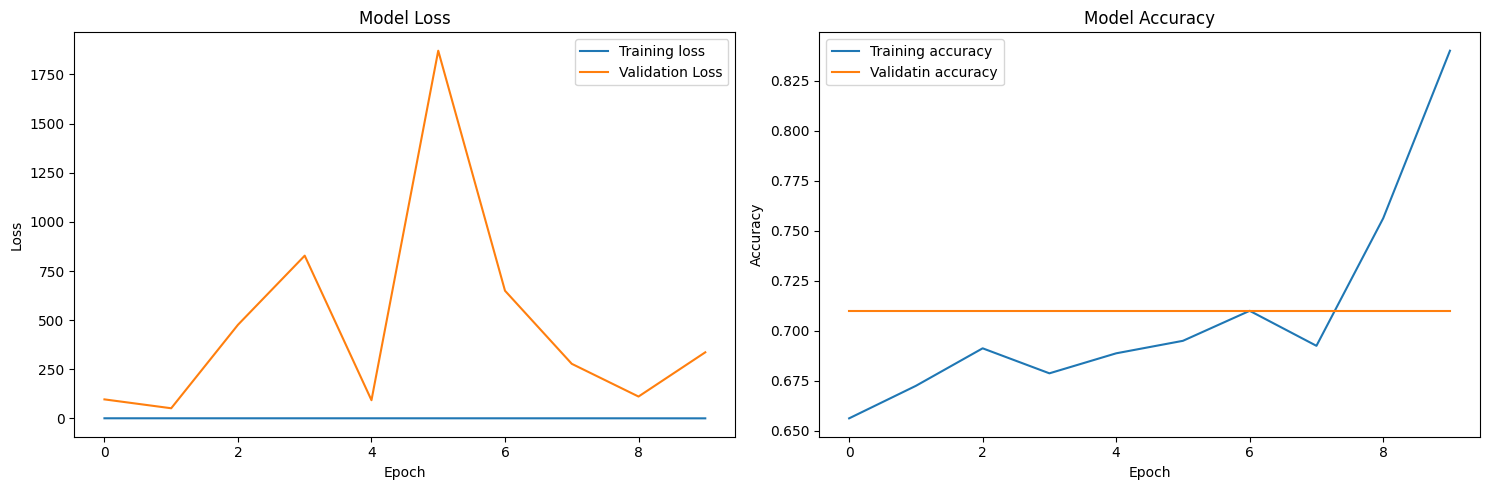

In [22]:
# execution
if __name__ == "__main__":
  # generate synthetic data
  images, tabular_data, labels = generate_synthetic_data(1000)
  # preprocess tabular data
  processed_tabular, label_encoders, numerical_scaler = preprocess_tabular_data(tabular_data)
  # split categorical and numerical features
  categorical_cols = ['gender', 'smoking_status'] # Corrected typo here: 'smoking_status'
  numerical_cols = ['age', 'blood_pressure', 'cholestrol', 'bmi']

  categorical_data = [processed_tabular[col].values.reshape(-1, 1) for col in categorical_cols]
  numerical_data = processed_tabular[numerical_cols].values
  # get cardinalities  for categorical variables
  categorical_cardinalities = [len(label_encoders[col].classes_) for col in categorical_cols]

  # split data
  indices = np.arange(len(images))
  train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

  # prepare training data
  X_train_img = images[train_idx]
  X_train_cat = [data[train_idx] for  data in categorical_data]
  X_train_num = numerical_data[train_idx] # Use indexing with brackets []
  y_train = labels[train_idx] # Use indexing with brackets []

  # prepare validation data
  X_val_img = images[val_idx]
  X_val_cat = [data[val_idx] for data in categorical_data]
  X_val_num = numerical_data[val_idx] # Use indexing with brackets []
  y_val = labels[val_idx] # Use indexing with brackets []

  # create and train model
  model = create_multilmodal_model(
      image_shape=(224, 224, 3),
      num_numerical_vars=len(numerical_cols),
      categorical_cardinalities=categorical_cardinalities
      )
  # train model
  history = train_model(
      model,
      ((X_train_img, X_train_cat, X_train_num), y_train),
      ((X_val_img, X_val_cat, X_val_num), y_val),
      epochs=10

  )
  plot_training_history(history)